# brain_tumor_classification.py

In [2]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, recall_score, f1_score
from torchmetrics import Recall, F1Score, Accuracy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

### 路径与设备

In [3]:
DATA_PATH = "D:/dl/brain tumor detection"
NO_PATH = os.path.join(DATA_PATH, "no")
YES_PATH = os.path.join(DATA_PATH, "yes")

assert os.path.exists(NO_PATH), f"路径不存在: {NO_PATH}"
assert os.path.exists(YES_PATH), f"路径不存在: {YES_PATH}"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


### 颅骨剥离

In [4]:
def skull_strip(img: np.ndarray) -> np.ndarray:
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    stripped = cv2.bitwise_and(img, img, mask=mask)
    return stripped

def skull_strip_transform(img):
    return skull_strip(np.array(img))

### Dataset

In [5]:
class BrainTumorDataset(Dataset):
    def __init__(self, no_paths, yes_paths, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform
        for p in no_paths:
            self.paths.append(os.path.join(NO_PATH, p))
            self.labels.append(0)
        for p in yes_paths:
            self.paths.append(os.path.join(YES_PATH, p))
            self.labels.append(1)
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        img = skull_strip(img)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

### EDA

In [6]:
def perform_eda():
    print("=== 执行 EDA ===")
    no_imgs = os.listdir(NO_PATH)
    yes_imgs = os.listdir(YES_PATH)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.pie([len(no_imgs), len(yes_imgs)], labels=["No Tumor", "Yes Tumor"], autopct='%1.1f%%')
    plt.title("类别分布")
    plt.subplot(1, 2, 2)
    sns.barplot(x=["No Tumor", "Yes Tumor"], y=[len(no_imgs), len(yes_imgs)], palette='viridis')
    plt.title("样本数量")
    plt.tight_layout()
    plt.savefig("eda_class_distribution.png", dpi=150, bbox_inches='tight')
    plt.show()

### 模型定义

In [7]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def get_resnet18(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

def get_efficientnet(num_classes=2):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

### 训练函数

In [8]:
def train_model(model, train_loader, val_loader, num_epochs=20, model_name="model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=False)
    
    train_metrics = {"loss": [], "recall": [], "f1": [], "accuracy": []}
    val_metrics = {"loss": [], "recall": [], "f1": [], "accuracy": []}
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_preds, train_labels = [], [], []
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            train_preds.append(outputs.detach())
            train_labels.append(labels.detach())
        
        model.eval()
        val_loss, val_preds, val_labels = [], [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())
                val_preds.append(outputs)
                val_labels.append(labels)
        
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)
        
        recall_fn = Recall(task="multiclass", num_classes=2, average='macro').to(device)
        f1_fn = F1Score(task="multiclass", num_classes=2, average='macro').to(device)
        acc_fn = Accuracy(task="multiclass", num_classes=2, average='macro').to(device)
        
        train_metrics["loss"].append(np.mean(train_loss))
        train_metrics["recall"].append(recall_fn(train_preds, train_labels).item())
        train_metrics["f1"].append(f1_fn(train_preds, train_labels).item())
        train_metrics["accuracy"].append(acc_fn(train_preds, train_labels).item())
        
        val_metrics["loss"].append(np.mean(val_loss))
        val_metrics["recall"].append(recall_fn(val_preds, val_labels).item())
        val_metrics["f1"].append(f1_fn(val_preds, val_labels).item())
        val_metrics["accuracy"].append(acc_fn(val_preds, val_labels).item())
        
        val_f1 = val_metrics["f1"][-1]
        scheduler.step(val_f1)
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"{model_name}_best.pth")
    
    torch.save(model.state_dict(), f"{model_name}_final.pth")
    
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(["loss", "recall", "f1", "accuracy"]):
        plt.subplot(2, 2, i+1)
        plt.plot(train_metrics[metric], label="Train")
        plt.plot(val_metrics[metric], label="Val")
        plt.title(f"{metric.upper()}")
        plt.xlabel("Epoch")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f"training_curves_{model_name}.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    return model, val_metrics

### 评估函数（返回概率用于 ROC）

In [9]:
def evaluate_model(model, test_loader, model_name="model"):
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))
    model.eval()
    all_preds, all_labels, all_probs = [], [], []
    
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"评估 {model_name}"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs)
    
    # 混淆矩阵
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Tumor", "Tumor"],
                yticklabels=["No Tumor", "Tumor"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"confusion_matrix_{model_name}.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    # 单独 ROC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend()
    plt.savefig(f"roc_curve_{model_name}.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    return {
        "Accuracy": accuracy_score(all_labels, all_preds),
        "Recall": recall_score(all_labels, all_preds),
        "F1": f1_score(all_labels, all_preds),
        "AUC": roc_auc
    }, all_labels, all_probs

### 综合 ROC 曲线（三个深度学习模型）

In [10]:
def plot_combined_roc(results_roc):
    plt.figure(figsize=(10, 8))
    for model_name, (labels, probs) in results_roc.items():
        fpr, tpr, _ = roc_curve(labels, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Comparison of Deep Learning Models')
    plt.legend(loc="lower right")
    plt.savefig("roc_curves_combined.png", dpi=150, bbox_inches='tight')
    plt.close()
    print("综合 ROC 曲线已保存为 'roc_curves_combined.png'")

### Grad-CAM

In [11]:
def visualize_gradcam(model, test_loader, model_name="model", save_name="gradcam"):
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))
    model.eval()
    
    if "resnet" in model_name:
        target_layers = [model.layer4[-1]]
    elif "efficientnet" in model_name:
        target_layers = [model.features[-1]]
    else:
        target_layers = [model.features[-2]]
    
    cam = GradCAM(model=model, target_layers=target_layers)
    
    plt.figure(figsize=(15, 12))
    count = 0
    for imgs, labels in test_loader:
        if count >= 8: break
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        for i in range(len(imgs)):
            if count >= 8: break
            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            grayscale_cam = cam(input_tensor=imgs[i].unsqueeze(0), 
                               targets=[ClassifierOutputTarget(preds[i].item())])[0, :]
            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
            plt.subplot(4, 4, count*2 + 1)
            true_label = "Tumor" if labels[i].item() == 1 else "No Tumor"
            pred_label = "Tumor" if preds[i].item() == 1 else "No Tumor"
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis('off')
            plt.subplot(4, 4, count*2 + 2)
            plt.imshow(visualization)
            plt.title(f"Grad-CAM\n{model_name}")
            plt.axis('off')
            count += 1
    plt.tight_layout()
    plt.savefig(f"{save_name}_{model_name}.png", dpi=150, bbox_inches='tight')
    plt.close()

### 模型比较表格

In [12]:
def compare_models(results):
    df = pd.DataFrame(results).T
    df.to_csv("model_comparison.csv")
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(["Accuracy", "Recall", "F1", "AUC"]):
        plt.subplot(2, 2, i+1)
        sns.barplot(x=df.index, y=df[metric], palette='viridis')
        plt.title(f'Model Comparison - {metric}')
        plt.ylim(0, 1.05)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("model_comparison.png", dpi=150, bbox_inches='tight')
    plt.close()
    print("\n模型比较结果:")
    print(df)
    return df

### 主流程

=== 执行 EDA ===


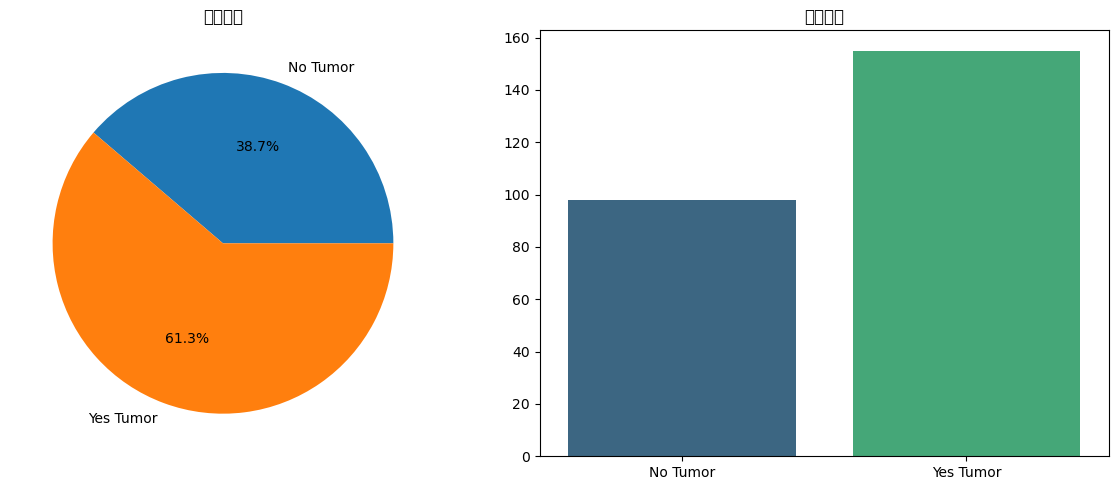

In [13]:
perform_eda()

In [14]:
no_imgs = os.listdir(NO_PATH)
yes_imgs = os.listdir(YES_PATH)

train_transform = transforms.Compose([
    transforms.Lambda(skull_strip_transform),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Lambda(skull_strip_transform),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = BrainTumorDataset(no_imgs, yes_imgs)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(123))

train_dataset = BrainTumorDataset(no_imgs, yes_imgs, transform=train_transform)
val_dataset = BrainTumorDataset(no_imgs, yes_imgs, transform=val_test_transform)
test_dataset = BrainTumorDataset(no_imgs, yes_imgs, transform=val_test_transform)

train_ds = Subset(train_dataset, train_ds.indices)
val_ds = Subset(val_dataset, val_ds.indices)
test_ds = Subset(test_dataset, test_ds.indices)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)

print(f"数据集划分: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

数据集划分: Train=177, Val=37, Test=39


In [15]:
all_results = {}
all_roc_data = {}  # 用于综合 ROC

In [16]:
# === SimpleCNN ===
print("\n=== 训练 SimpleCNN ===")
cnn_transform = transforms.Compose([
    transforms.Lambda(skull_strip_transform),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
cnn_dataset = BrainTumorDataset(no_imgs, yes_imgs, transform=cnn_transform)
cnn_train_ds = Subset(cnn_dataset, train_ds.indices)
cnn_val_ds = Subset(cnn_dataset, val_ds.indices)
cnn_test_ds = Subset(cnn_dataset, test_ds.indices)
cnn_train_loader = DataLoader(cnn_train_ds, batch_size=16, shuffle=True, num_workers=0)
cnn_val_loader = DataLoader(cnn_val_ds, batch_size=16, shuffle=False, num_workers=0)
cnn_test_loader = DataLoader(cnn_test_ds, batch_size=16, shuffle=False, num_workers=0)

cnn_model = SimpleCNN()
cnn_model, _ = train_model(cnn_model, cnn_train_loader, cnn_val_loader, num_epochs=30, model_name="cnn")
cnn_metrics, labels_cnn, probs_cnn = evaluate_model(cnn_model, cnn_test_loader, model_name="cnn")
all_results["SimpleCNN"] = cnn_metrics
all_roc_data["SimpleCNN"] = (labels_cnn, probs_cnn)
visualize_gradcam(cnn_model, cnn_test_loader, model_name="cnn", save_name="gradcam")


=== 训练 SimpleCNN ===


评估 cnn: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.85it/s]


In [17]:
# === ResNet18 ===
print("\n=== 训练 ResNet18 ===")
resnet_model = get_resnet18()
resnet_model, _ = train_model(resnet_model, train_loader, val_loader, num_epochs=30, model_name="resnet")
resnet_metrics, labels_res, probs_res = evaluate_model(resnet_model, test_loader, model_name="resnet")
all_results["ResNet18"] = resnet_metrics
all_roc_data["ResNet18"] = (labels_res, probs_res)
visualize_gradcam(resnet_model, test_loader, model_name="resnet", save_name="gradcam")


=== 训练 ResNet18 ===


评估 resnet: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.15it/s]


In [18]:
# === EfficientNet ===
print("\n=== 训练 EfficientNet-B0 ===")
efficientnet_model = get_efficientnet()
efficientnet_model, _ = train_model(efficientnet_model, train_loader, val_loader, num_epochs=30, model_name="efficientnet")
efficientnet_metrics, labels_eff, probs_eff = evaluate_model(efficientnet_model, test_loader, model_name="efficientnet")
all_results["EfficientNet-B0"] = efficientnet_metrics
all_roc_data["EfficientNet-B0"] = (labels_eff, probs_eff)
visualize_gradcam(efficientnet_model, test_loader, model_name="efficientnet", save_name="gradcam")


=== 训练 EfficientNet-B0 ===


评估 efficientnet: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  6.40it/s]


In [19]:
# === 综合分析 ===
plot_combined_roc(all_roc_data)
compare_models(all_results)

✅ 综合 ROC 曲线已保存为 'roc_curves_combined.png'

模型比较结果:
                 Accuracy  Recall        F1       AUC
SimpleCNN        0.743590    0.80  0.800000  0.848571
ResNet18         0.871795    0.88  0.897959  0.957143
EfficientNet-B0  0.948718    1.00  0.961538  0.942857


,Accuracy,Recall,F1,AUC
SimpleCNN,0.743590,0.80,0.800000,0.848571
ResNet18,0.871795,0.88,0.897959,0.957143
EfficientNet-B0,0.948718,1.00,0.961538,0.942857
